In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot
from lib.stats import pdf_from_samples, cdf_from_pdf

In [2]:
EXECUTION_NAME = datetime.now().replace(second=0, microsecond=0).isoformat()
PREPROCESSING_EXECUTION_NAME = "2024-06-09T18:27:00"
OUTPUT_PATH = '../data/'
EXECUTION_DURATION_S = 14*24*60*60; NS_TO_S = 1000000000
RANDOM_GEN = np.random.default_rng(seed=42)
PERCENTILES = [.5,.75,.9,.95,.99,.999]

In [3]:
DF = pd.read_csv(OUTPUT_PATH+PREPROCESSING_EXECUTION_NAME+'-EVENTS.csv.gz',
                 index_col='id')

In [4]:
DF

,app_id,func_id,end_ns,dur_ns,beg_ns,ts,req_id,event_type
id,,,,,,,,
0,8,63,79490900,78000000,1490900,1490900,0,1
1,64,150,57157860040,57154000000,3860040,3860040,1,1
2,64,146,59130477905,59125000000,5477905,5477905,2,1
3,0,245,6252541065,6236000000,16541065,16541065,3,1
4,8,374,66823959,50000000,16823959,16823959,4,1
...,...,...,...,...,...,...,...,...
3961897,19,376,1209598561518907,1000000,1209598560518907,1209598561518907,1980948,0
3961898,19,376,1209598628381967,1000000,1209598627381967,1209598627381967,1980949,1
3961899,19,376,1209598628381967,1000000,1209598627381967,1209598628381967,1980949,0


In [5]:
_count = -1
_app_id = -1
def get_count(app_id):
    global _count,_app_id
    if app_id == _app_id:
        _count += 1
    else:
        _count = 0
        _app_id = app_id
    return _count

In [6]:
def state_fabric():
    return {'current_requests': set(),
             'last_arrival_ts': 0,
             'last_departure_ts': 0,
             'last_event_ts': 0,
             'avg_active_count': 0,
             'activity_pc': 0,
             'idle_arrival_count': 0, 
             'duration': [],
             'active_count': dict(),
             'arrival_ts': [],
             'arrival_dt': [],
             'departure_dt': [],
             'arrival_departure_dt': [],
             'departure_arrival_dt': []}
def update_state(event, state):
    req_cnt = len(state['current_requests'])
    if req_cnt != 0:
        eventDt = event.ts - state['last_event_ts']
        state['avg_active_count'] += req_cnt*eventDt
        if req_cnt in state['active_count']:
            state['active_count'][req_cnt] += eventDt
        else:
            state['active_count'][req_cnt] = eventDt
        state['activity_pc'] += eventDt 
    if event.event_type == 1:
        state['arrival_ts'].append(event.ts)
        state['arrival_dt'].append(event.ts - state['last_arrival_ts'])
        state['departure_arrival_dt'].append(event.ts - state['last_departure_ts'])
        if len(state['current_requests']) != 0:
            state['idle_arrival_count'] += 1
        state['current_requests'].add(event.req_id)
        state['last_arrival_ts'] = event.ts
    else:
        state['departure_dt'].append(event.ts - state['last_departure_ts'])
        state['arrival_departure_dt'].append(event.ts - state['last_arrival_ts'])
        state['current_requests'].remove(event.req_id)
        state['last_departure_ts'] = event.ts
        state['duration'].append(event.dur_ns)
    state['last_event_ts'] = event.ts
def normalize_state(state):
    state['activity_pc'] /= (EXECUTION_DURATION_S*NS_TO_S)
    state['avg_active_count'] /= (state['activity_pc']*EXECUTION_DURATION_S*NS_TO_S)

In [7]:
STATE = {
    "global": state_fabric(),
    "app":dict(
        [*[app_id, state_fabric()]]
        for app_id in DF["app_id"].unique()),
    "func":dict(
        [*[func_id, state_fabric()]]
        for func_id in DF["func_id"].unique()),
}
for event in DF.itertuples():
    update_state(event, STATE["func"][event.func_id])
    update_state(event, STATE["app"][event.app_id])
    update_state(event, STATE["global"])
for state in STATE['func'].values():
    normalize_state(state)
for state in STATE['app'].values():
    normalize_state(state)
normalize_state(STATE['global'])

In [4]:
df_in = DF[DF['event_type'] == 1]
df_out = DF[DF['event_type'] == 0]

In [9]:
df_out['dur_ns'].describe(percentiles=PERCENTILES)

count    1.980951e+06
mean     3.347944e+09
std      1.850717e+10
min      0.000000e+00
50%      3.100000e+07
75%      3.720000e+08
90%      1.620000e+09
95%      1.441600e+10
99%      7.219950e+10
99.9%    2.536553e+11
max      5.786200e+11
Name: dur_ns, dtype: float64

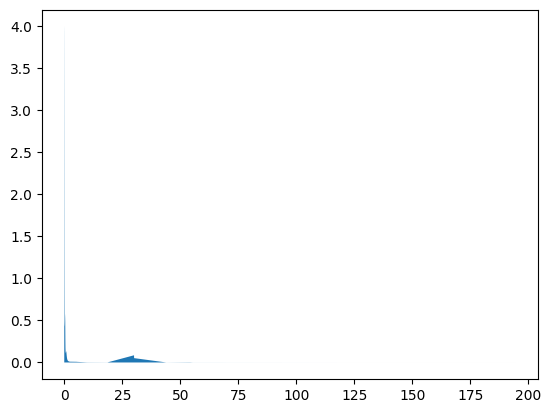

In [5]:
X_d, Y_d, kde = pdf_from_samples(df_out['dur_ns'].values/NS_TO_S)
pyplot.fill_between(X_d,Y_d)

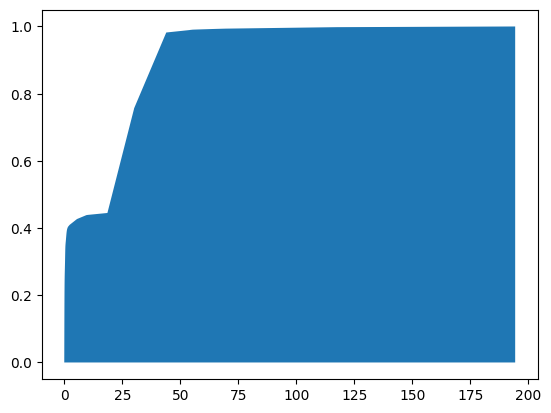

In [25]:
Y_c = cdf_from_pdf(X_d,Y_d)
pyplot.fill_between(X_d,Y_c)

In [13]:
# @dataclass
# class Bucket:
#     level = 0
#     timestamp: int 
#     functionID: int
#     applicationID: int
#     count: int
#     lastArrivalDt: float
#     lastDepartureDt: float
#     avgCount: Optional[float] = 0
#     maxCount: Optional[int] = 0   
#     arrivalCount: Optional[int] = 0
#     departureCount: Optional[int] = 0
#     avgRunningAge: Optional[float] = 0
#     virtualColdStarts: Optional[int] = 0
#     idlePc: Optional[float] = 0

# @dataclass
# class AppBucket:
#     level = 1
#     timestamp: int 
#     applicationID: int
#     count: int
#     lastArrivalDt: float
#     lastDepartureDt: float
#     avgCount: Optional[float] = 0
#     maxCount: Optional[int] = 0   
#     arrivalCount: Optional[int] = 0
#     departureCount: Optional[int] = 0
#     avgRunningAge: Optional[float] = 0
#     virtualColdStarts: Optional[int] = 0
#     idlePc: Optional[float] = 0

# @dataclass
# class GlobalBucket:
#     level = 2
#     timestamp: int 
#     count: int
#     lastArrivalDt: float
#     lastDepartureDt: float
#     avgCount: Optional[float] = 0
#     maxCount: Optional[int] = 0   
#     arrivalCount: Optional[int] = 0
#     departureCount: Optional[int] = 0
#     avgRunningAge: Optional[float] = 0
#     virtualColdStarts: Optional[int] = 0
#     idlePc: Optional[float] = 0

In [14]:
# buckets = [dict(),]*(EXECUTION_DURATION_S+1)
# buckets[0]['global'] = GlobalBucket(0, 0, 0, 0)
# for grp in range(1, len(buckets)):
#     df_grp = DF[DF['group'] == grp]
#     bucket = buckets[grp]
    
#     for event in df_grp.itertuples():
        
#         if STATE['func'][event.func_id]['count'] == None:
#             pass #init func
#             if STATE['app'][event.app_id]['count'] == None:
#                 pass #init app
#                 if STATE['global']['count'] == None:
#                    STATE['global']['current_requests'].add(event.req)
#                    STATE['global']['count'] = 0 
            
#         if event.func_id not in bucket:

#             func_state = STATE['func'][event.func_id]
#             bucket[event.func_id] = Bucket(event.ts, event.func_id, event.app_id,
                                           
                                        
#         else:
#             pass # departure